### This notebook is where I'm attempting to streamline our entire process, from the hacking to the binning of pandexo's error bars. The goal is to have a simple enough program that can be easily run for many transiting planet systems for our analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# my functions
from smoothing import adap_smooth
from run_pandexo import run_pandexo
from binning import bin_errs, calc_bin_widths, white_light_curve

### Hacking with ExoTransmit

In [2]:
# Can be found in kipping/Exo_Transmit/Spectra
# as of 19 Jan 2024
spectra_path = '/Users/coffey/Downloads/kipping/Exo_Transmit/Spectra'

In [3]:
# using ExoTransmit
t1_spectrum  = np.loadtxt(f'{spectra_path}/transmission_trappist1.dat', skiprows = 2).T #full 0.3 - 30 um
t1b_spectrum = np.loadtxt(f'{spectra_path}/transmission_trappist1b.dat', skiprows = 2).T
wave         = t1_spectrum[0][:2900] * 1e6 # microns
t1_spec      = t1_spectrum[1][:2900] / 100 # convert from %
t1b_spec     = t1b_spectrum[1][:2900] / 100 # convert from %

# flat spectrum = no atmosphere
Rs   = 6.957e8  # Sun
Rt1b = 7.118e6  # Trappist-1 b
Rt1  = 8.2927e7 # Trappist-1

t1b_depth     = (Rt1b / Rs)**2
flat_t1b_spec = np.repeat(t1b_depth, len(t1_spec))

# for comparison, T1b around T1 w/ ExoTransmit
t1b_og_spectrum  = np.loadtxt(f'{spectra_path}/transmission_t1b_around_t1_noaerosols.dat', skiprows = 2).T
t1b_og_spec      = t1b_og_spectrum[1][:2900] * 1e4

In [4]:
# for plotting (dotted line)
t1bt1_fixed_depth = (Rt1b/Rt1)**2 * 1e6 # fixed transit depth of T1b around T1

In [5]:
# Multiplying out the Sun's radius
t1b_spec_noRs      = np.sqrt(t1b_spec) * Rs
t1_spec_noRs       = np.sqrt(t1_spec) * Rs
flat_t1b_spec_noRs = np.sqrt(flat_t1b_spec) * Rs

# combining the spectra for our new (Rp/Rs)^2
hacked_spec      = (t1b_spec_noRs / t1_spec_noRs)**2 * 1e6      # ppm
flat_hacked_spec = (flat_t1b_spec_noRs / t1_spec_noRs)**2 * 1e6 # ppm

# smoothing to JWST resolution (R ~ 100 for prism)
smooth_hacked_spec = adap_smooth(wave, hacked_spec, R = 100)
smooth_flat_hacked_spec = adap_smooth(wave, flat_hacked_spec, R = 100)

smooth_t1b_spec = adap_smooth(wave, t1b_spec, R = 100)
smooth_t1_spec = adap_smooth(wave, t1_spec, R = 100)
smooth_og_spec = adap_smooth(wave, t1b_og_spec, R = 100)


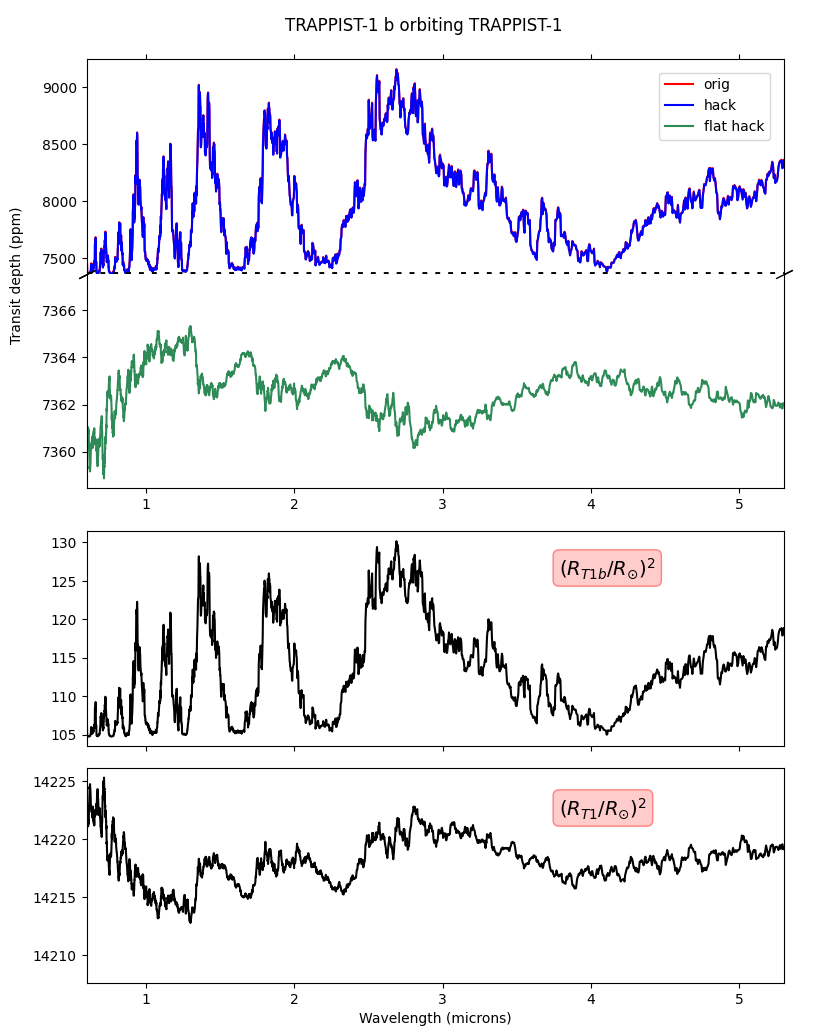

In [6]:
# added a couple invisible axis elements to give space b/w last two plots while 
# closing the space between the first two
fig, axs = plt.subplots(6, 1, figsize = (9,12), height_ratios = [1,1,0.2,1,0.1,1], sharex = True)
fig.subplots_adjust(hspace = 0)

# Spectra
axs[0].plot(wave, smooth_og_spec, c = 'red')
axs[0].plot(wave, smooth_hacked_spec, c = 'blue')
axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen')
axs[3].plot(wave, np.array(smooth_t1b_spec) * 1e6, c = 'black')
axs[5].plot(wave, np.array(smooth_t1_spec) * 1e6, c = 'black')
fig.legend(['orig', 'hack', 'flat hack'], loc = (0.805,0.865))

# Broken axis
axs[0].set_ylim(t1bt1_fixed_depth, None)
axs[1].set_ylim(None, t1bt1_fixed_depth)
axs[0].spines.bottom.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[0].xaxis.tick_top()
axs[1].tick_params(labeltop=True)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()
axs[1].xaxis.grid(True, which='minor')
axs[2].set_visible(False)
axs[4].set_visible(False)

# Slanted lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], ms=12,ls="none", c='k', mec='k', mew=1, clip_on=False)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

axs[0].set_xlim(0.6,5.3)

# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 3.5)

# Labels
fig.suptitle('TRAPPIST-1 b orbiting TRAPPIST-1', y = 0.915)
fig.text(0.04, 0.7, 'Transit depth (ppm)', va='center', rotation='vertical')
fig.text(0.65, 0.45, r'$(R_{T1b}/R_{\odot})^2$', fontsize = 14, bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
fig.text(0.65, 0.25, r'$(R_{T1}/R_{\odot})^2$', fontsize = 14, bbox=dict(boxstyle='round',ec=(1., 0.5, 0.5),fc=(1., 0.8, 0.8),))
axs[5].set_xlabel('Wavelength (microns)')
plt.show()

## Super smooth

In [7]:
supersmooth_hacked_spec = adap_smooth(wave, hacked_spec, R = 25)
supersmooth_flat_hacked_spec = adap_smooth(wave, flat_hacked_spec, R = 25)

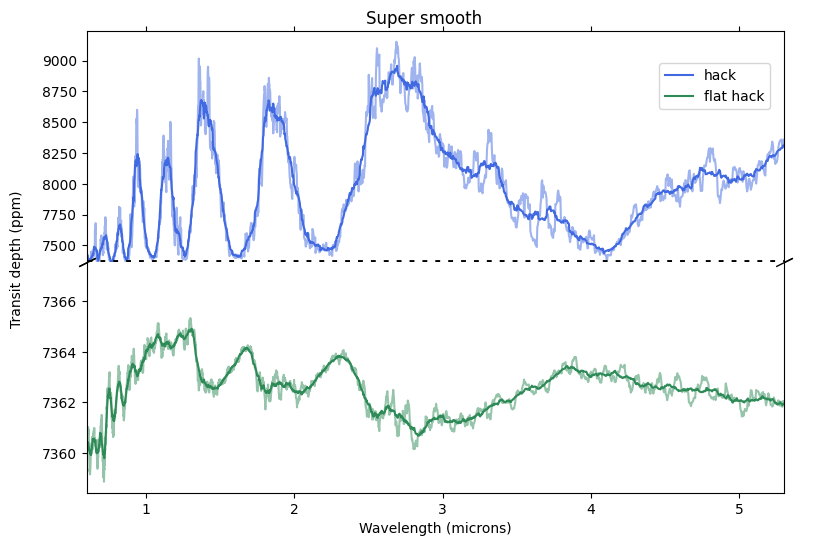

In [8]:
# added a couple invisible axis elements to give space b/w last two plots while 
# closing the space between the first two
fig, axs = plt.subplots(2, 1, figsize = (9,6), height_ratios = [1,1], sharex = True)
fig.subplots_adjust(hspace = 0)

# Spectra
axs[0].plot(wave, smooth_hacked_spec, c = 'royalblue', alpha = 0.5, label = '_nolegend_')
axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen', alpha = 0.5, label = '_nolegend_')
axs[0].plot(wave, supersmooth_hacked_spec, c = 'royalblue')
axs[1].plot(wave, supersmooth_flat_hacked_spec, c = 'seagreen')
fig.legend(['hack','flat hack'], loc = (0.805,0.8))

# Broken axis
axs[0].set_ylim(t1bt1_fixed_depth, None)
axs[1].set_ylim(None, t1bt1_fixed_depth)
axs[0].spines.bottom.set_visible(False)
axs[1].spines.top.set_visible(False)
axs[0].xaxis.tick_top()
axs[1].tick_params(labeltop=True)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()
axs[1].xaxis.grid(True, which='minor')

# Slanted lines
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], ms=12,ls="none", c='k', mec='k', mew=1, clip_on=False)
axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)

# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 3.5)

axs[0].set_xlim(0.6,5.3)

# Labels
fig.suptitle('Super smooth', y = 0.915)
fig.text(0.04, 0.5, 'Transit depth (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')
plt.show()

## Run pandexo

In [9]:
err_wave, err = run_pandexo('trappist', 11.354, 'J', star_temp = 2566, star_metal = -1.4, star_logg = 5.276,
                       trans_dur = 0.6, star_radius = 0.119, planet_radius = 0.0996)

Running Single Case for: NIRSpec Prism
Optimization Reqested: Computing Duty Cycle
Finished Duty Cycle Calc
Starting Out of Transit Simulation
End out of Transit
Starting In Transit Simulation
End In Transit


## Binning pandexo errors

In [10]:
R = 25
new_errs, new_wave, dellambs = bin_errs(err_wave, err, R)

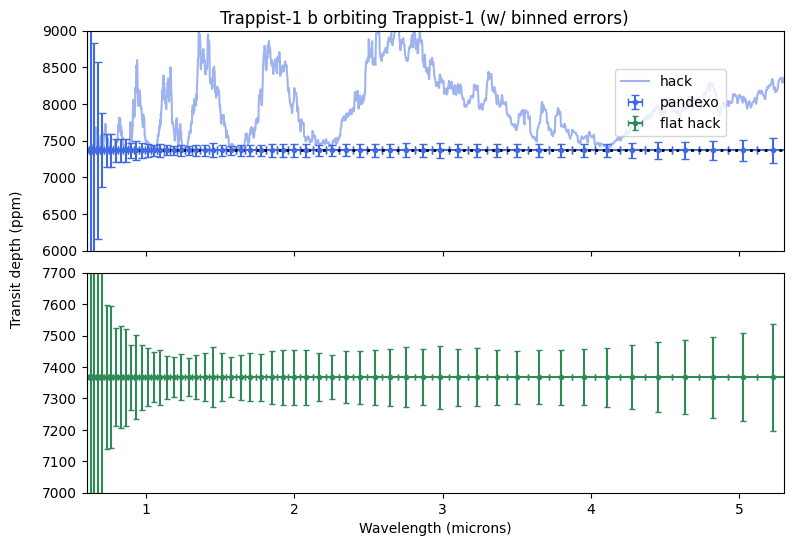

In [11]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)
axs[1].set_xlim(0.6, 5.3)
axs[0].set_ylim(6000,9000)
axs[1].set_ylim(7000,7700)

# Spectra
axs[0].plot(wave, smooth_hacked_spec, c = 'royalblue', alpha = 0.5)
#axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen', alpha = 0.5)
axs[0].errorbar(new_wave, [t1bt1_fixed_depth] * len(new_wave), 
                yerr = new_errs, xerr = np.array(dellambs) / 2, capsize = 3, fmt = '.', c = 'royalblue')
axs[1].errorbar(new_wave, [t1bt1_fixed_depth] * len(new_wave), 
                yerr = new_errs, xerr = np.array(dellambs) / 2, capsize = 2, fmt = '.', c = 'seagreen')


# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 2, label = '_nolegend_')

# Labels
fig.legend(['hack','pandexo', 'flat hack', 'pandexo'], loc = (0.775,0.75))
fig.suptitle('Trappist-1 b orbiting Trappist-1 (w/ binned errors)', y = 0.915)
fig.text(0.04, 0.5, 'Transit depth (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')
plt.show()

In [12]:
# checking if the bin edges overlap or have a gap
for i in range(len(new_errs)):
    left_bin_edge = new_wave[i] - dellambs[i]/2
    right_bin_edge = new_wave[i-1] + dellambs[i-1]/2
    
    if left_bin_edge == right_bin_edge:
        print("they kiss")
    elif left_bin_edge < right_bin_edge:
        print(f"we're fucked by {right_bin_edge - left_bin_edge} u")
    elif left_bin_edge > right_bin_edge:
        print(f"there's a gap of {left_bin_edge - right_bin_edge} u")

we're fucked by 4.739897455753482 u
there's a gap of 1.1102230246251565e-16 u
there's a gap of 1.1102230246251565e-16 u
they kiss
there's a gap of 1.1102230246251565e-16 u
they kiss
they kiss
they kiss
they kiss
they kiss
we're fucked by 1.1102230246251565e-16 u
they kiss
there's a gap of 1.1102230246251565e-16 u
they kiss
they kiss
they kiss
they kiss
they kiss
we're fucked by 2.220446049250313e-16 u
they kiss
there's a gap of 2.220446049250313e-16 u
there's a gap of 2.220446049250313e-16 u
they kiss
they kiss
they kiss
they kiss
they kiss
they kiss
there's a gap of 2.220446049250313e-16 u
they kiss
we're fucked by 2.220446049250313e-16 u
they kiss
we're fucked by 4.440892098500626e-16 u
they kiss
there's a gap of 4.440892098500626e-16 u
they kiss
they kiss
they kiss
they kiss
they kiss
they kiss
they kiss
they kiss
there's a gap of 4.440892098500626e-16 u
there's a gap of 4.440892098500626e-16 u
there's a gap of 4.440892098500626e-16 u
they kiss
there's a gap of 4.440892098500626e-16

In [13]:
# shifting the wavelength values for the error bars to 
# closest values for the wavelength array corresponding to the spectrum
# so that I can plot the error bars onto the spectrum itself

newer_wave = []
indices = []
for i in range(len(new_wave)):
    index = (np.abs(wave - new_wave[i])).argmin()
    indices.append(index)
    newer_wave.append(wave[index])

In [14]:
len(newer_wave) == len(new_wave)

True

(0.4, 0.6)

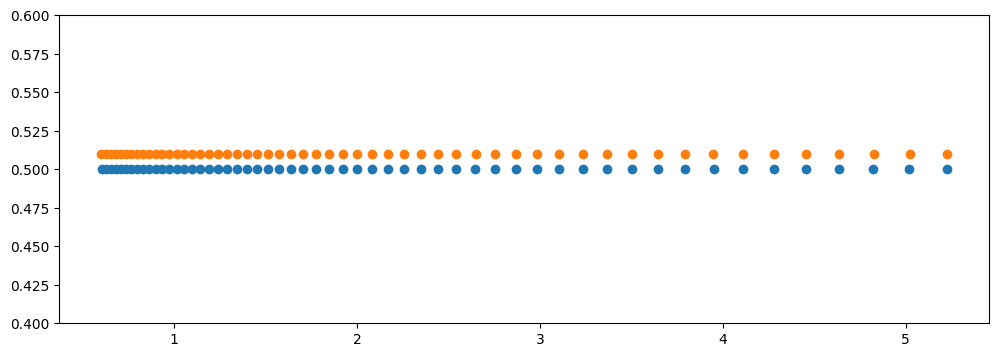

In [15]:
# plotting them together to show the slight shift
plt.figure(figsize = (12,4))
plt.plot(new_wave, [0.5] *len(new_wave), 'o')
plt.plot(newer_wave, [0.51] *len(newer_wave), 'o')
plt.ylim(0.4,0.6)

In [16]:
print('mean shift: ', np.mean(np.array(new_wave) - np.array(newer_wave)))
print('max shift: ', np.max(np.array(new_wave) - np.array(newer_wave)))

mean shift:  -4.863829387185598e-05
max shift:  0.0019211512425565402


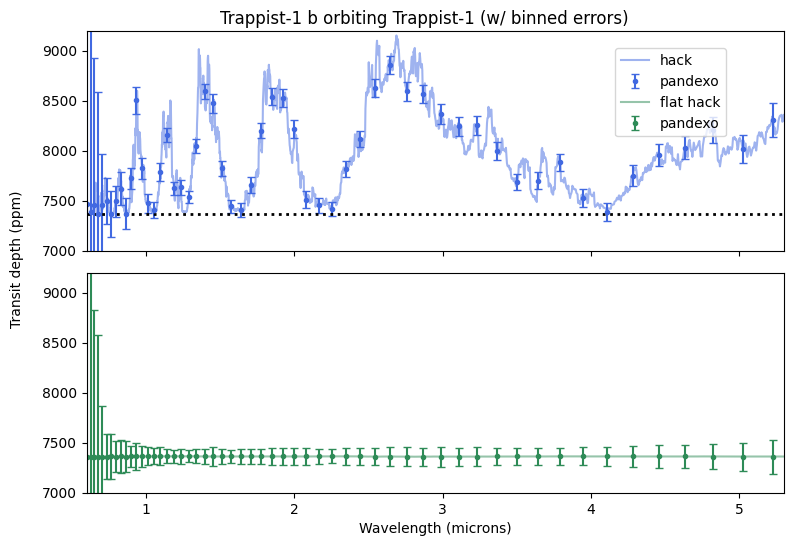

In [17]:
fig, axs = plt.subplots(2, 1, figsize = (9,6), sharex = True)
fig.subplots_adjust(hspace = 0.1)
axs[1].set_xlim(0.6,5.3)
axs[0].set_ylim(7000,9200)
axs[1].set_ylim(7000,9200)

# Spectra
axs[0].plot(wave, smooth_hacked_spec, c = 'royalblue', alpha = 0.5)
axs[1].plot(wave, smooth_flat_hacked_spec, c = 'seagreen', alpha = 0.5)
axs[0].errorbar(newer_wave, np.take(smooth_hacked_spec, indices), 
                yerr = new_errs, capsize = 3, fmt = '.', c = 'royalblue')
axs[1].errorbar(newer_wave, np.take(smooth_flat_hacked_spec, indices), 
                yerr = new_errs, capsize = 3, fmt = '.', c = 'seagreen')


# Plotting fixed transit depth to compare
axs[0].axhline(y = t1bt1_fixed_depth, c = 'black', ls = 'dotted', lw = 2, label = '_nolegend_')

# Labels
fig.legend(['hack','pandexo', 'flat hack', 'pandexo'], loc = (0.775,0.75))
fig.suptitle('Trappist-1 b orbiting Trappist-1 (w/ binned errors)', y = 0.915)
fig.text(0.04, 0.5, 'Transit depth (ppm)', va='center', rotation='vertical')
axs[1].set_xlabel('Wavelength (microns)')
plt.show()

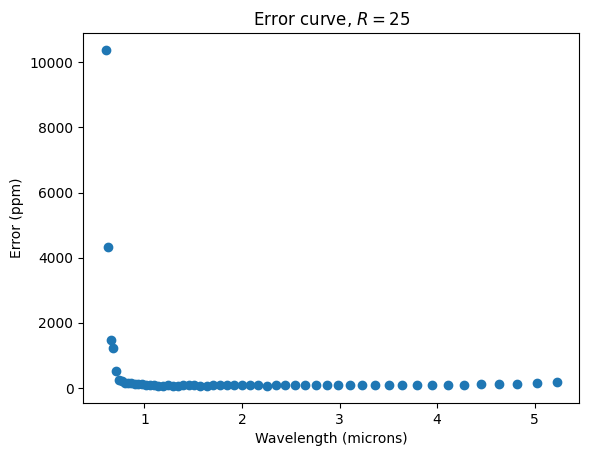

In [18]:
plt.plot(newer_wave, new_errs, 'o')

plt.xlabel('Wavelength (microns)')
plt.ylabel('Error (ppm)')
plt.title(f'Error curve, $R = {R}$')
plt.show()